<a href="https://colab.research.google.com/github/72653804/72653804.github.io/blob/main/PrintSafe_AI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# SECCIÓN 0 — Preparación del entorno

from google.colab import drive
drive.mount('/content/drive')

# Librerías principales
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta del dataset
base_path = "/content/drive/MyDrive/ViralPrint-AI/dataset"

train_dir = base_path   # Keras buscará infractor/ y no_infractor/


In [ ]:
# SECCIÓN 1 — Carga del dataset y Data Augmentation

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,  # 20% será para validación
    rotation_range=25,
    zoom_range=0.20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

# Generador de validación
val_generator = train_datagen.flow_from_directory(
    base_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

print("\nClases detectadas por el modelo:")
print(train_generator.class_indices)

Found 1847 images belonging to 2 classes.
Found 461 images belonging to 2 classes.

Clases detectadas por el modelo:
{'infractor': 0, 'no_infractor': 1}


In [ ]:
# SECCIÓN 2 — Construcción y entrenamiento del modelo MobileNetV2

# Cargar MobileNetV2 sin la parte final
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Entrenamiento inicial congelado

# Construcción del modelo final
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilación inicial
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ENTRENAMIENTO INICIAL
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1
)

# SECCIÓN 4.1 — Fine Tuning del modelo

# Descongelamos el modelo base completo
base_model.trainable = True

# Congelamos las primeras capas para evitar sobreajuste
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-Compilamos con un learning rate más bajo
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento fino
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1
)

# GUARDAR MODELO FINAL EN FORMATO COMPATIBLE (WINDOWS FRIENDLY)
import tensorflow as tf

tf.keras.models.save_model(
    model,
    "/content/drive/MyDrive/model.h5",   # ← Nombre final simple
    save_format="h5",
    include_optimizer=False              # ← Importante
)

print("Modelo final guardado correctamente como model.h5")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 851s 15s/step - accuracy: 0.6104 - loss: 0.7039 - val_accuracy: 0.7983 - val_loss: 0.4279
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.8350 - loss: 0.3860 - val_accuracy: 0.8395 - val_loss: 0.3583
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8695 - loss: 0.3135 - val_accuracy: 0.8503 - val_loss: 0.3514
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9065 - loss: 0.2343 - val_accuracy: 0.8850 - val_loss: 0.2908
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.9018 - loss: 0.2622 - val_accuracy: 0.9024 - val_loss: 0.2553
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9265 - loss: 0.2100 - val_accuracy: 0.9067 - val_loss: 0.2495
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.9096 - loss: 0.2101 - val_accuracy: 0.9262 - val_loss: 0.2319
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.9257 - loss: 0.1820 - val_accuracy: 0.9067 - 

Modelo final guardado correctamente como model.h5


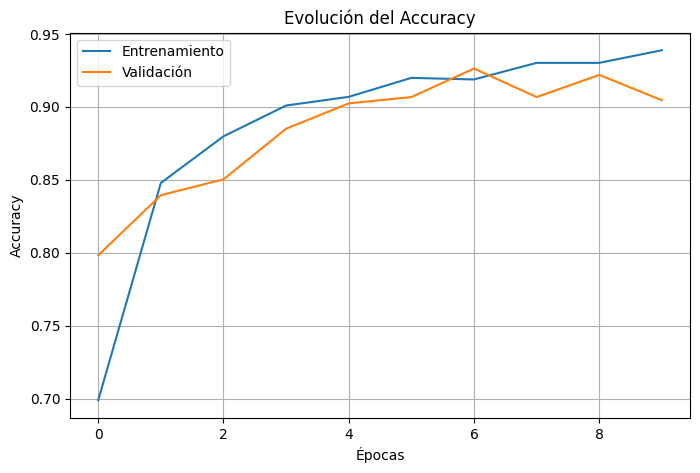

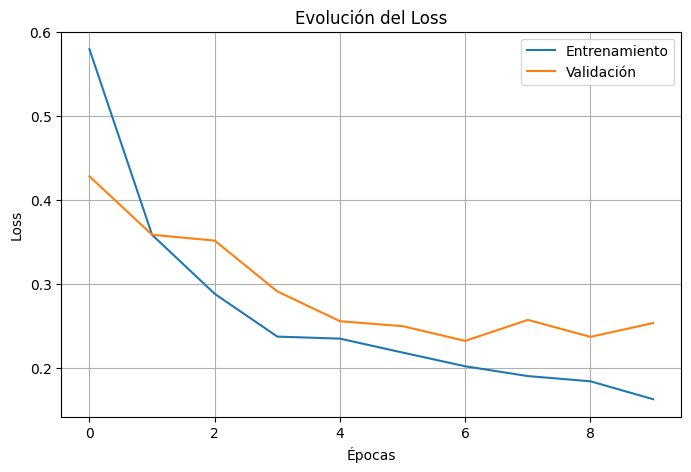

In [ ]:
# SECCIÓN 3 — Gráficas de métricas del entrenamiento

import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución del Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución del Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


15/15 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
Classification Report:

              precision    recall  f1-score   support

   Infractor       0.59      0.64      0.62       265
No infractor       0.46      0.41      0.43       196

    accuracy                           0.54       461
   macro avg       0.53      0.52      0.52       461
weighted avg       0.54      0.54      0.54       461



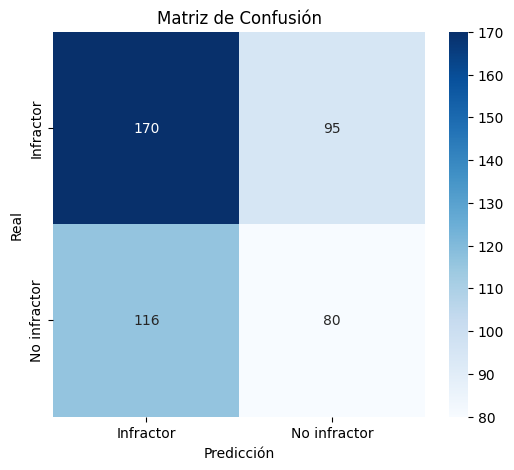

In [ ]:
# SECCIÓN 4.1 — Fine Tuning del modelo

# Descongelar algunas capas del modelo base para mejorar el aprendizaje
base_model.trainable = True

# Congelaremos las primeras capas para evitar sobreajuste
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilamos nuevamente con una tasa de aprendizaje más pequeña
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Entrenamiento fino
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,   # 5 épocas son suficientes
    verbose=1
)

# Guardamos el modelo actualizado
model.save("/content/drive/MyDrive/PrintSafeAI_MobileNetV2_FineTuned.keras")


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.8557 - loss: 0.3089 - val_accuracy: 0.9024 - val_loss: 0.2661
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9184 - loss: 0.2251 - val_accuracy: 0.9067 - val_loss: 0.2263
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9360 - loss: 0.1837 - val_accuracy: 0.9176 - val_loss: 0.2454
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9310 - loss: 0.1613 - val_accuracy: 0.9197 - val_loss: 0.2225
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.9463 - loss: 0.1600 - val_accuracy: 0.9241 - val_loss: 0.2223


15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step
Classification Report:

              precision    recall  f1-score   support

   Infractor       0.58      0.60      0.59       265
No infractor       0.43      0.40      0.41       196

    accuracy                           0.52       461
   macro avg       0.50      0.50      0.50       461
weighted avg       0.51      0.52      0.51       461



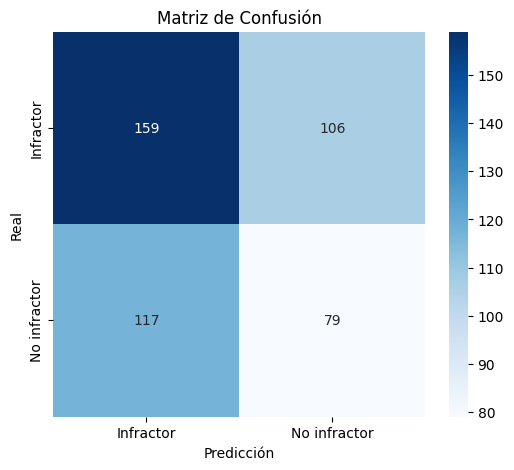

In [ ]:
# SECCIÓN 4 — Evaluación final del modelo ACTUALIZADO

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener predicciones
val_generator.reset()
preds = model.predict(val_generator)
pred_labels = (preds > 0.5).astype(int)

true_labels = val_generator.classes

# Classification report
print("Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=["Infractor", "No infractor"]))

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Infractor", "No infractor"], yticklabels=["Infractor", "No infractor"])
plt.title("Matriz de Confusión")
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()

In [ ]:
# ===============================
# SECCIÓN 5 — EXPLICABILIDAD CON GRAD-CAM
# ===============================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Función Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        pred_output = predictions[:, pred_index]

    grads = tape.gradient(pred_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap


# Función para cargar una imagen en formato correcto
def load_and_preprocess(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img, img_array


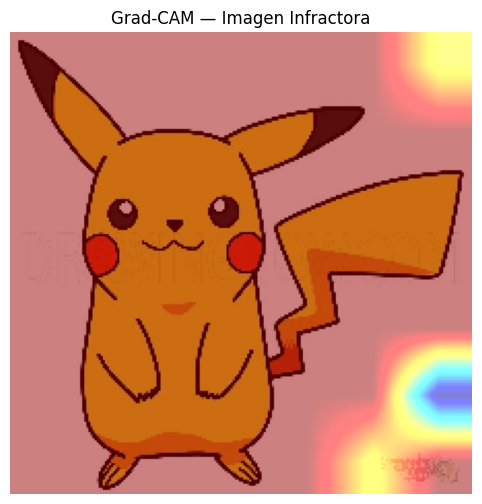

In [ ]:
# ===============================
# SECCIÓN 5.1 — EXPLICABILIDAD CON GRAD-CAM
# ===============================
# Imagen infractora
test_image_path = "/content/drive/MyDrive/ViralPrint-AI/dataset/infractor/pikachu_png_0016.jpg"

orig_img, img_array = load_and_preprocess(test_image_path)

heatmap = make_gradcam_heatmap(img_array, model, "Conv_1")

# Superponer heatmap con la imagen original
heatmap = cv2.resize(heatmap, (orig_img.size[0], orig_img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.array(orig_img), 0.5, heatmap_color, 0.6, 0)

plt.figure(figsize=(8,6))
plt.imshow(superimposed_img)
plt.title("Grad-CAM — Imagen Infractora")
plt.axis("off")
plt.show()


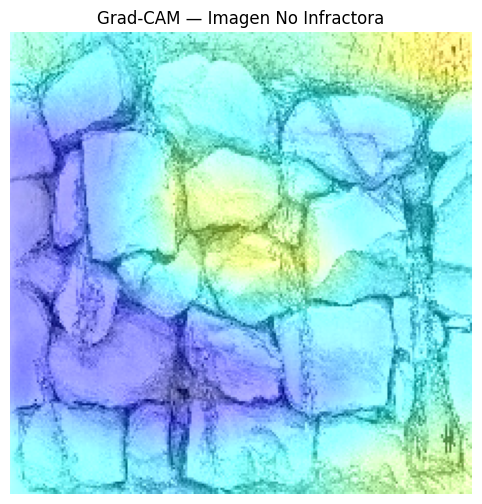

In [ ]:
# ===============================
# SECCIÓN 5.2 — EXPLICABILIDAD CON GRAD-CAM
# ===============================
# Imagen no infractora
test_image_path = "/content/drive/MyDrive/ViralPrint-AI/dataset/no_infractor/stone_texture_20.jpg"

orig_img, img_array = load_and_preprocess(test_image_path)

heatmap = make_gradcam_heatmap(img_array, model, "Conv_1")

heatmap = cv2.resize(heatmap, (orig_img.size[0], orig_img.size[1]))
heatmap = np.uint8(255 * heatmap)
heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(np.array(orig_img), 0.7, heatmap_color, 0.5, 0)

plt.figure(figsize=(8,6))
plt.imshow(superimposed_img)
plt.title("Grad-CAM — Imagen No Infractora")
plt.axis("off")
plt.show()


In [ ]:
# =============================================
# SECCIÓN 6 — Función para predecir una imagen
# =============================================
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image

# Diccionario de clases detectadas
class_names = ["infractor", "no_infractor"]

def predict_image(path, model):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predicción
    pred = model.predict(img_array)[0][0]

    # Mayor probabilidad a clase "1"
    label = "no_infractor" if pred > 0.5 else "infractor"

    prob = pred if pred > 0.5 else 1 - pred

    print("\n=====================================")
    print(f"Imagen analizada: {path}")
    print(f"Predicción del modelo: {label.upper()}")
    print(f"Probabilidad: {prob:.4f}")
    print("=====================================")

    # Mostrar imagen
    img_disp = cv2.imread(path)
    img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
    plt.imshow(img_disp)
    plt.title(f"{label.upper()}  |  Prob={prob:.2f}")
    plt.axis("off")
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Imagen analizada: /content/drive/MyDrive/ViralPrint-AI/pruebas_reales/fondo_patricio.jpg
Predicción del modelo: INFRACTOR
Probabilidad: 0.9929


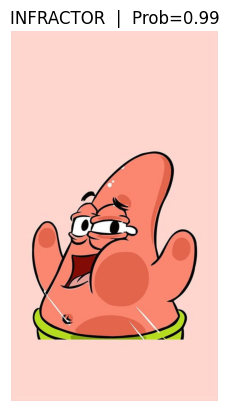

In [ ]:
# ================================================
# SECCIÓN 6.1 — Pruebas con datos nuevos INFRACTORA
# ================================================

test_path = "/content/drive/MyDrive/ViralPrint-AI/pruebas_reales/fondo_patricio.jpg"
predict_image(test_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Imagen analizada: /content/drive/MyDrive/ViralPrint-AI/pruebas_reales/roca.jpg
Predicción del modelo: NO_INFRACTOR
Probabilidad: 0.9676


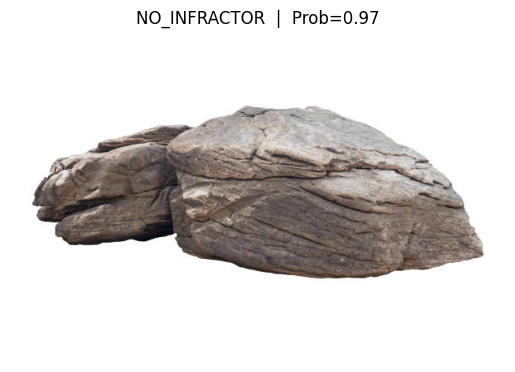

In [ ]:
# ================================================
# SECCIÓN 6.2 — Pruebas con datos nuevos NO INFRACTORA
# ================================================
test_path = "/content/drive/MyDrive/ViralPrint-AI/pruebas_reales/roca.jpg"
predict_image(test_path, model)


In [ ]:
import tensorflow as tf
from keras import saving

# Cargar tu modelo original entrenado con Keras 3
model_v3 = tf.keras.models.load_model("/content/drive/MyDrive/PrintSafeAI_MobileNetV2_FineTuned.keras")

# Convertir al formato legacy H5 compatible con TF 2.x
saving.save_model(
    model_v3,
    "/content/drive/MyDrive/model_FINAL.h5",
    overwrite=True,
    save_format="h5"
)

print("🎉 Modelo convertido correctamente a model_FINAL.h5 (compatible con Windows) 🎉")



🎉 Modelo convertido correctamente a model_FINAL.h5 (compatible con Windows) 🎉
